In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyteomics import mzml
from sklearn.preprocessing import MinMaxScaler

pd.options.plotting.backend = "ms_matplotlib"

In [3]:
# Load manually annotated peak boundaries
groundtruth = pd.read_csv("Spyogenes_manual_annotation.tsv", sep = "\t")

In [4]:
# Load library
library = pd.read_csv("Spyogenes_library.tsv", sep = "\t")
library["diann_id"] = library["FullUniModPeptideName"] + library["PrecursorCharge"].astype(str)

In [5]:
target_precursor = "AADGQTVSGGSILYR3"
chroms_precursor = pickle.load(open("chroms_%s.pkl" % target_precursor, "rb"))

groundtruth_precursor = groundtruth[groundtruth["precursor_id"] == target_precursor]
library_precursor = library[library["diann_id"] == target_precursor]
target_anno = pd.DataFrame({"product_mz" : library_precursor["ProductMz"].values, 
                            "ion_annotation" : (library_precursor["FragmentType"] + library_precursor["FragmentSeriesNumber"].astype(str) + "_" + library_precursor["FragmentCharge"].astype(str)).values})

In [6]:
def build_chrom_df(chroms_precursor, target_anno):
    df = {"rt" : [], "int" : [], "ion_annotation" : [], "run" : []}
    for run in list(chroms_precursor.keys()):
        for frag_int, frag_anno in zip(chroms_precursor[run][1], chroms_precursor[run][3]):
            df["rt"].extend(chroms_precursor[run][0])
            df["int"].extend(frag_int)
            df["ion_annotation"].extend([frag_anno] * len(chroms_precursor[run][0]))
            df["run"].extend([run] * len(chroms_precursor[run][0]))
    return pd.DataFrame(df)

In [7]:
chrom_df = build_chrom_df(chroms_precursor, target_anno)

In [8]:
plot_runs = ["run0_Strep0Repl1_R01", 
             "run4_Strep0Repl2_R02", 
             "run12_Strep0Repl1_R04", 
             "run7_Strep10Repl1_R02", 
             "run11_Strep10Repl2_R03", 
             "run15_Strep10Repl2_R04"]
plot_run_names = ["Run #0 Spyogenes 0% human plasma", 
                  "Run #1 Spyogenes 0% human plasma", 
                  "Run #2 Spyogenes 0% human plasma", 
                  "Run #3 Spyogenes 10% human plasma", 
                  "Run #4 Spyogenes 10% human plasma", 
                  "Run #5 Spyogenes 10% human plasma"]
chrom_df = chrom_df[chrom_df["run"].isin(plot_runs)]

In [9]:
chrom_df["int"] = MinMaxScaler().fit_transform(chrom_df["int"].to_frame())[:, 0]

In [10]:
chrom_df.head()

,rt,int,ion_annotation,run
0,2461.450,0.008121,MS2_y10,run0_Strep0Repl1_R01
1,2464.864,0.003709,MS2_y10,run0_Strep0Repl1_R01
2,2468.277,0.009468,MS2_y10,run0_Strep0Repl1_R01
3,2471.690,0.002343,MS2_y10,run0_Strep0Repl1_R01
4,2475.104,0.006081,MS2_y10,run0_Strep0Repl1_R01


In [11]:
fig, axs = plt.subplots(len(np.unique(chrom_df["run"])), 1, figsize=(10, 7))
plt.close()

plot_list = []
i = 0
for run in plot_runs:
    run_df = chrom_df[chrom_df["run"] == run]
    
    if i == len(plot_runs) // 2:
        show_legend = True
    else:
        show_legend = False

    #if i == 0:
    #    title = "$AADGQTVSGGSILYR^{3+}$\n\n%s" % plot_run_names[i]
    #else:
    #    title = plot_run_names[i]
    title = plot_run_names[i] 

    groundtruth_precursor_run = groundtruth_precursor[groundtruth_precursor["run_id"] == run]
    annotation_df = pd.DataFrame({"leftWidth" : [list(groundtruth_precursor_run["left"])[0]], 
                                  "rightWidth" : [list(groundtruth_precursor_run["right"])[0]], 
                                  "apexIntensity" : [100]})
    
    p = run_df.plot(kind="chromatogram", x="rt", y="int", 
                    grid=False,  by="ion_annotation", 
                    title = title,
                    title_font_size = 16,
                    xaxis_label_font_size = 16,
                    yaxis_label_font_size = 16,
                    xaxis_tick_font_size = 14,
                    yaxis_tick_font_size = 14,
                    fig=axs[i],
                    relative_intensity=True, 
                    annotation_data = annotation_df, 
                    legend={'show':False, 'title':"Transition"})
    plot_list.append(p)
    i+=1

for i in range(len(plot_list)):
    if i != len(plot_list) - 1:
        plot_list[i].fig.set_xticklabels([])
        plot_list[i].fig.set_xticks([])
        plot_list[i].fig.set_xlabel("")
    else:
        plot_list[i].fig.set_xlabel("Retention Time (sec)")
    if i != len(plot_list) // 2:
        plot_list[i].fig.set_ylabel("")
    else:
        plot_list[i].fig.set_ylabel("Relative Intensity")

    plot_list[i].fig.get_legend().remove()
fig.tight_layout()
#fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.6, wspace=0.2)

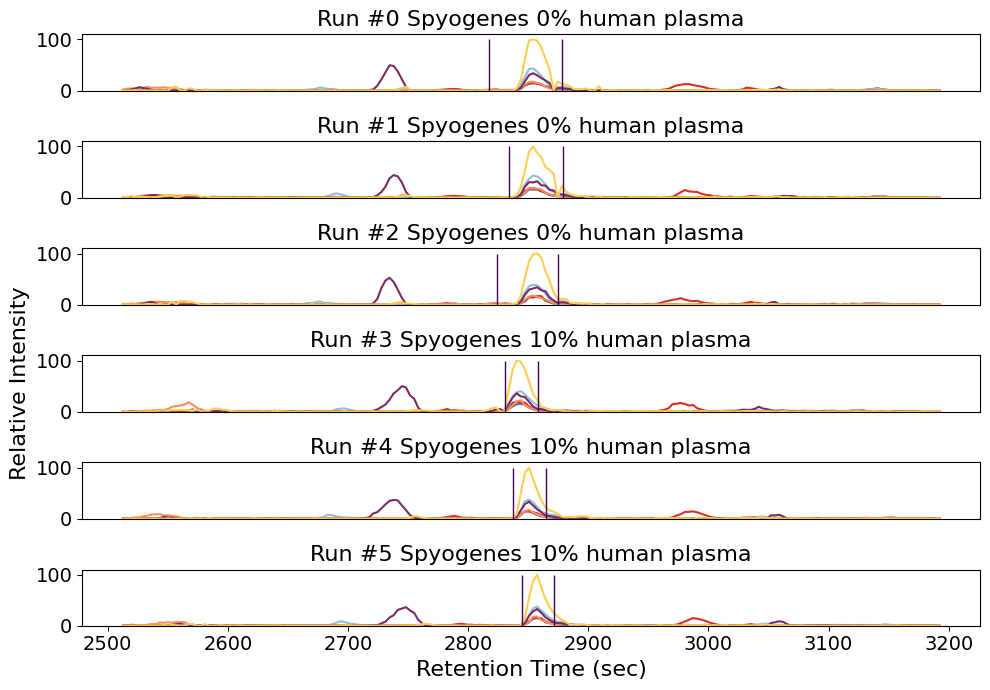

In [12]:
fig